# Business Problem

Chicago needs to face an epidemic of violence within the city. One way to face the problem is to use machine learning to determine how many victims of violent crime to expect on a given day. Using data from the city of Chicago, I will train regression models to predict upcoming crimes.

The underlying principal of this project is fairly intuitive: violent acts will lead to more violent acts. However, this project will examine the victims of violent crime in Chicago and see if differing victims (different ages, sexes, races, etc) effect predictions for future violent crime.

The model itself be created for the Chicago government to help predict the amount of first responders needed on a given day. For example, if a spike in crime occurs on a given day, the Chicago PD can proactively schedule more police officers and 911 operators.

In [1]:
# Importing and settings
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from statsmodels.formula.api import ols
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import shap
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_columns', None)

## Loading Data and Cleaning

First the data needs to be loaded in and checked to make sure that there is no missing data. I will also ensure there are no odd values.

In [2]:
df = pd.read_csv('violent_crime.csv')

# Standardize column headers
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')

In [3]:
df.head(3)

,case_number,date,block,primary_type,unique_id,zip_code,ward,community_area,street_outreach_organization,area,district,beat,age,sex,race,fbi_cd,fbi_descr,iucr_cd,iucr_secondary,month,day_of_week,hour,latitude,longitude,location
0,HZ100096,01/01/2016 02:04:00 AM,4600 S ST LAWRENCE,FATAL SHOOTING,HOM-HZ100096-1,60653,4,GRAND BOULEVARD,None,1,2,221,20 - 29,M,BLK,01A,HOMICIDE - 1ST OR 2ND DEGREE (INDEX),0110,FIRST DEGREE MURDER,1,6,2,41.810127,-87.611604,POINT (-87.611604058699 41.810126904142)
1,HZ100342,01/01/2016 06:39:00 AM,1900 W GARFIELD BLVD,FATAL SHOOTING,HOM-HZ100342-1,60609,16,NEW CITY,PBMR New City,1,9,932,30 - 39,M,BLK,01A,HOMICIDE - 1ST OR 2ND DEGREE (INDEX),0110,FIRST DEGREE MURDER,1,6,6,41.794218,-87.673175,POINT (-87.67317465388 41.794218345858)
2,HZ101042,01/01/2016 10:06:00 PM,6100 S SANGAMON ST,FATAL SHOOTING,HOM-HZ101042-1,60621,16,ENGLEWOOD,TADC Englewood | READI 60621,1,7,712,30 - 39,M,BLK,01A,HOMICIDE - 1ST OR 2ND DEGREE (INDEX),0110,FIRST DEGREE MURDER,1,6,22,41.782338,-87.647905,POINT (-87.64790465388 41.782338345858)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20036 entries, 0 to 20035
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   case_number                   20036 non-null  object 
 1   date                          20036 non-null  object 
 2   block                         20036 non-null  object 
 3   primary_type                  20036 non-null  object 
 4   unique_id                     20036 non-null  object 
 5   zip_code                      20036 non-null  int64  
 6   ward                          20036 non-null  int64  
 7   community_area                20036 non-null  object 
 8   street_outreach_organization  20036 non-null  object 
 9   area                          20036 non-null  int64  
 10  district                      20036 non-null  int64  
 11  beat                          20036 non-null  int64  
 12  age                           19801 non-null  object 
 13  s

In [5]:
# Info shows that there are missing values in age, race, and sex. 
# Will fill in with corresponding unknown values their columns.

df['age'].fillna('UNKNOWN', inplace=True)
df['sex'].fillna('UNKNOWN', inplace=True)
df['race'].fillna('(NOT PROVIDED)', inplace=True)

In [6]:
# Sex has a few ambiguous values, so going to put them under one banner
df['sex'].replace(['UNKNOWN','X', '(NOT PROVIDED)'], 'SEX_UNKNOWN', inplace=True)
df['sex'].unique()

array(['M', 'F', 'SEX_UNKNOWN'], dtype=object)

In [7]:
df['street_outreach_organization'].value_counts()

None                                                         5100
READI 60644 | INVC Austin                                    1132
UCAN North Lawndale | READI 60623                             875
TADC Englewood | READI 60621                                  864
ALSO Humboldt Park                                            825
                                                             ... 
SWOP Gage Park | READI 60631                                    1
UCAN North Lawndale | READI 60623 | Enlace South Lawndale       1
TADC West Englewood                                             1
TADC Englewood | READI 60621 | Acclivus Washington Park         1
READI 60623 | New Life Centers Brighton Park                    1
Name: street_outreach_organization, Length: 78, dtype: int64

There is a feature in the data about community outreach available near where the crime happened. There are many different organizations, some with value counts of 1, so I am going make it a more binary predictor of whether or not street outreache was available.

In [8]:
def help_available(string):
    if string == 'None':
        return 'no'
    else:
        return 'yes'

In [9]:
df['so_yes_no'] = df['street_outreach_organization'].map(help_available)

## Early Data Analysis

Now that I'm satisfied with the data, it is important to look at the data and see if there are any trends that may effect the model, or if there are any opportunities for feature engineering. 

In [83]:
df['so_yes_no'].value_counts(normalize=True)

yes    0.745458
no     0.254542
Name: so_yes_no, dtype: float64

In [84]:
df['sex'].value_counts(normalize=True)

M              0.861499
F              0.126273
SEX_UNKNOWN    0.012228
Name: sex, dtype: float64

In [85]:
df['race'].value_counts(normalize=True)

BLK               0.784688
WWH               0.157317
WHI               0.025504
(NOT PROVIDED)    0.020663
WBH               0.006488
API               0.003843
U                 0.001298
I                 0.000200
Name: race, dtype: float64

In [86]:
df['age'].value_counts(normalize=True)

20 - 29    0.446896
30 - 39    0.216261
0 - 19     0.200040
40 - 49    0.074466
50 - 59    0.034438
60 - 69    0.012577
UNKNOWN    0.011729
70 - 79    0.002446
80+        0.001148
Name: age, dtype: float64

So far there is nothing too surprsing in the data. I am going to eventually look into applying my model to specific neighborhoods, so I want to see where victims are concentrated.

In [13]:
df_loc = df.groupby('community_area', as_index=False).count()

In [14]:
df_loc = df_loc[['community_area', 'unique_id']]
df_loc

,community_area,unique_id
0,ALBANY PARK,99
1,ARCHER HEIGHTS,40
2,ARMOUR SQUARE,63
3,ASHBURN,122
4,AUBURN GRESHAM,818
...,...,...
72,WEST LAWN,58
73,WEST PULLMAN,514
74,WEST RIDGE,97
75,WEST TOWN,301


In [15]:
chi_nei = gpd.read_file('location_data/CommAreas.shp')

In [16]:
merge_loc = chi_nei.merge(df_loc, left_on='COMMUNITY', right_on='community_area')

In [17]:
merge_loc[merge_loc['unique_id'] > 800][['COMMUNITY', 'unique_id']]

,COMMUNITY,unique_id
23,HUMBOLDT PARK,972
25,AUSTIN,2086
26,WEST GARFIELD PARK,889
29,NORTH LAWNDALE,1227
64,WEST ENGLEWOOD,833
65,ENGLEWOOD,885
69,AUBURN GRESHAM,818


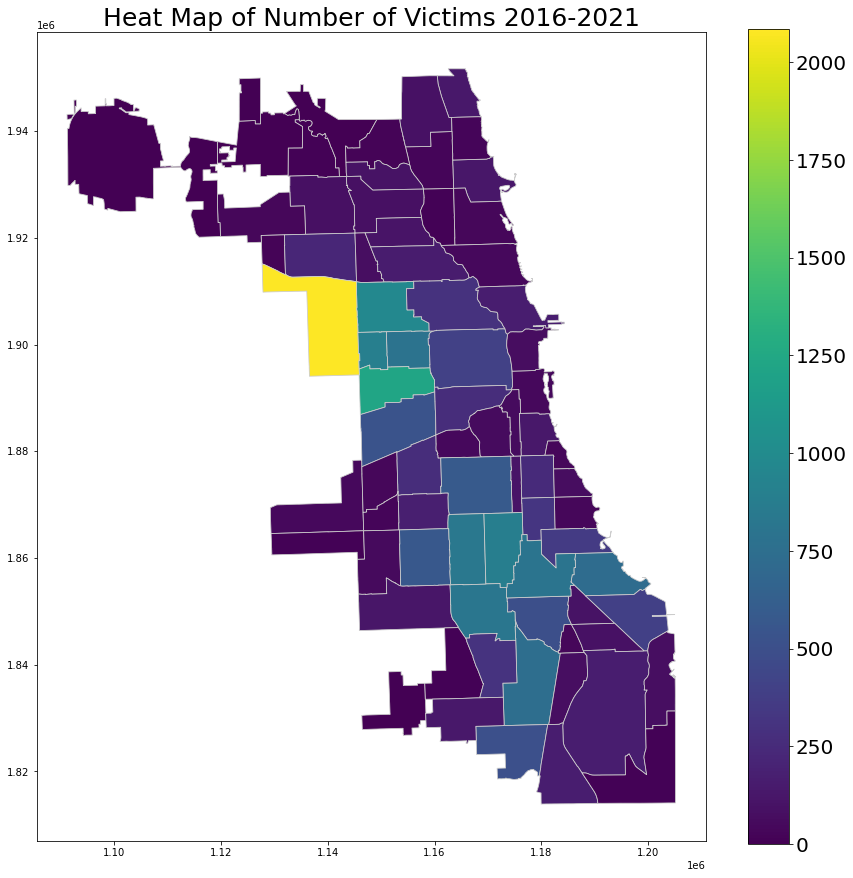

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Heat Map of Number of Victims 2016-2021', fontdict={'fontsize': '25', 'fontweight': '1'})
vmin, vmax = 0, 2086
sc_ma = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
sc_ma._A = []
cbar = fig.colorbar(sc_ma)
cbar.ax.tick_params(labelsize=20)
merge_loc.plot('unique_id', linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));

We can see that violent crime appears to be be clustered heavily in west side of the city (mostly Austin), with a smaller cluster in the south side.

Next, I want to format the dates and see if there are any patterns in temporal data (day of week, month and month of the year).

In [19]:
# Formatting date and adding specification of month and year
df['date'] = pd.to_datetime(df['date'])
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
df['date'] = df['date'].dt.to_period('D')

In [20]:
df_dow = df.groupby('day_of_week').count()

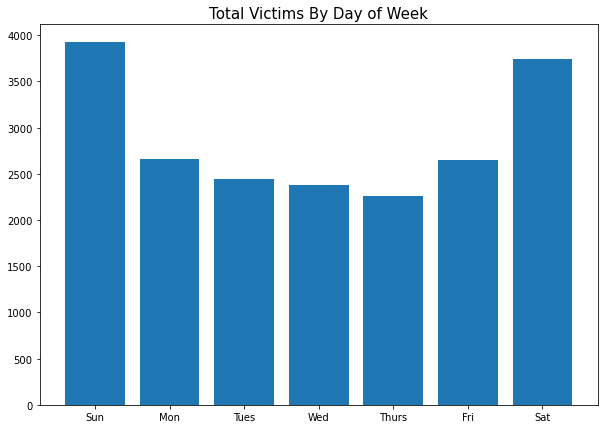

In [21]:
day_list = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']

fig, ax = plt.subplots(figsize=(10,7))
ax.bar(day_list ,df_dow['unique_id'])
ax.set_title('Total Victims By Day of Week', fontdict={'fontsize': '15'});

In [22]:
df_month = df.groupby('month').count()
df_month.reset_index(inplace=True)

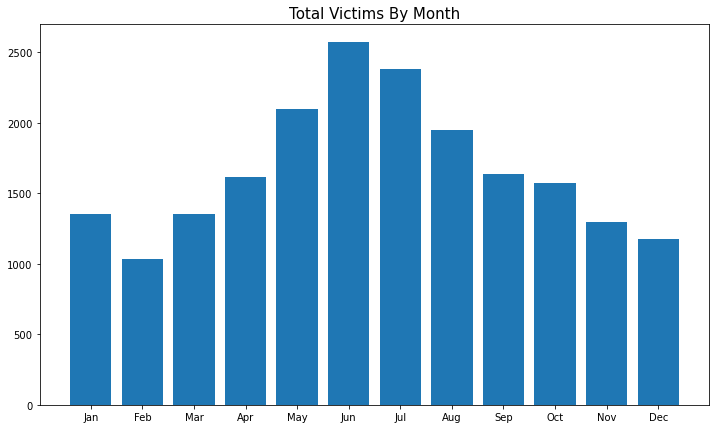

In [23]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(12,7))
ax.bar(month_list ,df_month['unique_id'])
ax.set_title('Total Victims By Month', fontdict={'fontsize': '15'});

In [24]:
# df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')

In [25]:
df_month_year = df.groupby('month_year').count()
df_month_year.reset_index(inplace=True)

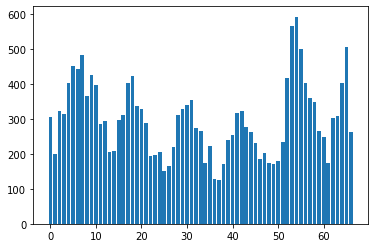

In [26]:
plt.bar(df_month_year.index, df_month_year['unique_id']);

We can see patterns in all of the temporal data:

* There tends to be victims on weekends
* There appears to be more victims in hotter months
* Up until 2020, violent crime was on a downward trend

Based on this, I will expect that day of week, month, and month_year will be good predictors in my model. Let's find out!

## Formatting Data

Right now, each row of data is one victim of a violent crime. However, I want the model to predict the total number of vicitms on a given day. Additionally, a lot of data is numeric when I would like it to be categorical (ie day of week is 1-7 rather than name of the day). Finally, I want to get a count of the different type of victims (victims by age, sex, proximity to street outreach, etc).

In [27]:
# Changing types to fatal or non-fatal

df['primary_type'].replace(['NON-SHOOTING HOMICIDE', 'FATAL SHOOTING'], 'fatal', inplace=True)
df['primary_type'].replace(['NON-FATAL SHOOTING'], 'non_fatal', inplace=True)

In [28]:
# Function to one hot encode categorical features

def cat_encoder(category, enc_df):
    ohe = OneHotEncoder(handle_unknown='error', sparse=False)
    
    temp_df = enc_df[[category]]
    ohe.fit(temp_df)

    cat_encoded = pd.DataFrame(ohe.transform(temp_df).astype(int), \
                               columns=(category+'_'+ohe.categories_[0]))
    return cat_encoded

In [29]:
# Originally was going to not use 
# df = df[df['date'] < '2020-01-01']

df.columns

Index(['case_number', 'date', 'block', 'primary_type', 'unique_id', 'zip_code',
       'ward', 'community_area', 'street_outreach_organization', 'area',
       'district', 'beat', 'age', 'sex', 'race', 'fbi_cd', 'fbi_descr',
       'iucr_cd', 'iucr_secondary', 'month', 'day_of_week', 'hour', 'latitude',
       'longitude', 'location', 'so_yes_no', 'month_year'],
      dtype='object')

For the first models, I am going to focus on non-spatial data, and essentially throw everything else in and check out what appears to be good indicators for models. From there, I can set up a new dataframe with the best features to see if the models will become more accurate.

In [30]:
model_vars = ['date', 'primary_type', 'day_of_week', 'month', 'month_year', 'so_yes_no', 'beat', 
              'age', 'sex', 'race', 'community_area']
model_df = df[model_vars]
model_df = model_df.astype(str)

In [31]:
# Everything but date needs to be encoded

need_enc = list(model_df.columns[1:])

for col in need_enc:
    loop_df = cat_encoder(str(col), model_df)
    model_df = pd.concat([model_df, loop_df], axis=1)

In [32]:
model_df = model_df.groupby('date').sum()

In [33]:
model_df.head(3)

,primary_type_fatal,primary_type_non_fatal,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_year_2016-01,month_year_2016-02,month_year_2016-03,month_year_2016-04,month_year_2016-05,month_year_2016-06,month_year_2016-07,month_year_2016-08,month_year_2016-09,month_year_2016-10,month_year_2016-11,month_year_2016-12,month_year_2017-01,month_year_2017-02,month_year_2017-03,month_year_2017-04,month_year_2017-05,month_year_2017-06,month_year_2017-07,month_year_2017-08,month_year_2017-09,month_year_2017-10,month_year_2017-11,month_year_2017-12,month_year_2018-01,month_year_2018-02,month_year_2018-03,month_year_2018-04,month_year_2018-05,month_year_2018-06,month_year_2018-07,month_year_2018-08,month_year_2018-09,month_year_2018-10,month_year_2018-11,month_year_2018-12,month_year_2019-01,month_year_2019-02,month_year_2019-03,month_year_2019-04,month_year_2019-05,month_year_2019-06,month_year_2019-07,month_year_2019-08,month_year_2019-09,month_year_2019-10,month_year_2019-11,month_year_2019-12,month_year_2020-01,month_year_2020-02,month_year_2020-03,month_year_2020-04,month_year_2020-05,month_year_2020-06,month_year_2020-07,month_year_2020-08,month_year_2020-09,month_year_2020-10,month_year_2020-11,month_year_2020-12,month_year_2021-01,month_year_2021-02,month_year_2021-03,month_year_2021-04,month_year_2021-05,month_year_2021-06,month_year_2021-07,so_yes_no_no,so_yes_no_yes,beat_1011,beat_1012,beat_1013,beat_1014,beat_1021,beat_1022,beat_1023,beat_1024,beat_1031,beat_1032,beat_1033,beat_1034,beat_111,beat_1111,beat_1112,beat_1113,beat_1114,beat_1115,beat_112,beat_1121,beat_1122,beat_1123,beat_1124,beat_1125,beat_113,beat_1131,beat_1132,beat_1133,beat_1134,beat_1135,beat_114,beat_121,beat_1211,beat_1212,beat_1213,beat_1214,beat_1215,beat_122,beat_1221,beat_1222,beat_1223,beat_1224,beat_1225,beat_123,beat_1231,beat_1232,beat_1233,beat_1234,beat_1235,beat_124,beat_131,beat_132,beat_133,beat_1411,beat_1412,beat_1413,beat_1414,beat_1421,beat_1422,beat_1423,beat_1424,beat_1431,beat_1432,beat_1433,beat_1434,beat_1511,beat_1512,beat_1513,beat_1522,beat_1523,beat_1524,beat_1531,beat_1532,beat_1533,beat_1611,beat_1613,beat_1614,beat_1622,beat_1623,beat_1624,beat_1631,beat_1632,beat_1633,beat_1634,beat_1654,beat_1711,beat_1712,beat_1713,beat_1722,beat_1723,beat_1724,beat_1731,beat_1732,beat_1733,beat_1811,beat_1812,beat_1813,beat_1814,beat_1821,beat_1822,beat_1823,beat_1824,beat_1831,beat_1832,beat_1833,beat_1834,beat_1911,beat_1912,beat_1913,beat_1914,beat_1915,beat_1921,beat_1922,beat_1923,beat_1924,beat_1925,beat_1931,beat_1932,beat_1933,beat_1934,beat_1935,beat_2011,beat_2012,beat_2013,beat_2022,beat_2023,beat_2024,beat_2031,beat_2032,beat_2033,beat_211,beat_212,beat_213,beat_214,beat_215,beat_221,beat_2211,beat_2212,beat_2213,beat_222,beat_2221,beat_2222,beat_2223,beat_223,beat_2232,beat_2233,beat_2234,beat_224,beat_225,beat_231,beat_232,beat_233,beat_234,beat_235,beat_2411,beat_2412,beat_2413,beat_2422,beat_2423,beat_2424,beat_2431,beat_2432,beat_2433,beat_2511,beat_2512,beat_2513,beat_2514,beat_2515,beat_2521,beat_2522,beat_2523,beat_2524,beat_2525,beat_2531,beat_2532,beat_2533,beat_2534,beat_2535,beat_311,beat_312,beat_313,beat_314,beat_321,beat_322,beat_323,beat_324,beat_331,beat_332,beat_333,beat_334,beat_411,beat_412,beat_413,beat_414,beat_421,beat_422,beat_423,beat_424,beat_431,beat_432,beat_433,beat_434,beat_511,beat_512,beat_513,beat_522,beat_523,beat_524,beat_531,beat_532,beat_533,beat_611,beat_612,beat_613,beat_614,beat_621,beat_622,beat_623,beat_624,beat_631,beat_632,beat_633,beat_634,beat_711,beat_712,beat_713,beat_714,beat_715,beat_722,beat_723,beat_724,beat_725,beat_726,beat_731,beat_732,beat_733,beat_734,beat_735,beat_811,beat_812,beat_813,beat_814,beat_815,beat_821,beat_822,beat_823,beat_824,beat_825,beat_831,beat_832,beat_833,beat_834,beat_835,beat_911,beat_912,beat_913,beat

The target of the model is total victims on a given day. As such, I can add all victims of fatal and non-fatal incidents to get the total victims.

In [34]:
target = model_df['primary_type_fatal'] + model_df['primary_type_non_fatal']
target

date
2016-01-01    18
2016-01-02     9
2016-01-03    12
2016-01-04     6
2016-01-05    13
              ..
2021-07-09    12
2021-07-10    26
2021-07-11    11
2021-07-12    10
2021-07-13    14
Length: 2016, dtype: int64

Now the data is arranged by date, and I have a count of victims by different categories on each day. However, in some cases I want the data to be binary, like day of week, month, and month_year.

In [35]:
# Function to change sum to binary

def binary_maker(num):
    if num > 0:
        return 1
    else:
        return 0

In [36]:
# Using function on day and month features

# for col in model_df.columns:
#     if 'day' in col or 'month' in col:
#         model_df[col] = model_df[col].map(binary_maker)

In [37]:
# Separating sum and binary data

time_list = []
count_list = []

for col in model_df.columns:
    if 'day' in col or 'month' in col:
        time_list.append(col)
    else:
        count_list.append(col)
        
time_df = model_df[time_list]

In [38]:
# Using function on day and month features

for col in time_df:
    time_df[col] = time_df[col].map(binary_maker)

# Will use rolling function for past two days for sum data, so need to drop the first two rows for binary data 
time_df = time_df[2:]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
# model_df.set_index('date', inplace=True)

# Get rolling sum of victims from last two days
model_df = model_df[count_list]
model_df = model_df.rolling(window=2).sum()

# Remove first two rows
model_df = model_df[2:]

# Concat the rolling and binary data
model_df = pd.concat([model_df, time_df], axis=1)

In [40]:
model_df.head(1)

,primary_type_fatal,primary_type_non_fatal,so_yes_no_no,so_yes_no_yes,beat_1011,beat_1012,beat_1013,beat_1014,beat_1021,beat_1022,beat_1023,beat_1024,beat_1031,beat_1032,beat_1033,beat_1034,beat_111,beat_1111,beat_1112,beat_1113,beat_1114,beat_1115,beat_112,beat_1121,beat_1122,beat_1123,beat_1124,beat_1125,beat_113,beat_1131,beat_1132,beat_1133,beat_1134,beat_1135,beat_114,beat_121,beat_1211,beat_1212,beat_1213,beat_1214,beat_1215,beat_122,beat_1221,beat_1222,beat_1223,beat_1224,beat_1225,beat_123,beat_1231,beat_1232,beat_1233,beat_1234,beat_1235,beat_124,beat_131,beat_132,beat_133,beat_1411,beat_1412,beat_1413,beat_1414,beat_1421,beat_1422,beat_1423,beat_1424,beat_1431,beat_1432,beat_1433,beat_1434,beat_1511,beat_1512,beat_1513,beat_1522,beat_1523,beat_1524,beat_1531,beat_1532,beat_1533,beat_1611,beat_1613,beat_1614,beat_1622,beat_1623,beat_1624,beat_1631,beat_1632,beat_1633,beat_1634,beat_1654,beat_1711,beat_1712,beat_1713,beat_1722,beat_1723,beat_1724,beat_1731,beat_1732,beat_1733,beat_1811,beat_1812,beat_1813,beat_1814,beat_1821,beat_1822,beat_1823,beat_1824,beat_1831,beat_1832,beat_1833,beat_1834,beat_1911,beat_1912,beat_1913,beat_1914,beat_1915,beat_1921,beat_1922,beat_1923,beat_1924,beat_1925,beat_1931,beat_1932,beat_1933,beat_1934,beat_1935,beat_2011,beat_2012,beat_2013,beat_2022,beat_2023,beat_2024,beat_2031,beat_2032,beat_2033,beat_211,beat_212,beat_213,beat_214,beat_215,beat_221,beat_2211,beat_2212,beat_2213,beat_222,beat_2221,beat_2222,beat_2223,beat_223,beat_2232,beat_2233,beat_2234,beat_224,beat_225,beat_231,beat_232,beat_233,beat_234,beat_235,beat_2411,beat_2412,beat_2413,beat_2422,beat_2423,beat_2424,beat_2431,beat_2432,beat_2433,beat_2511,beat_2512,beat_2513,beat_2514,beat_2515,beat_2521,beat_2522,beat_2523,beat_2524,beat_2525,beat_2531,beat_2532,beat_2533,beat_2534,beat_2535,beat_311,beat_312,beat_313,beat_314,beat_321,beat_322,beat_323,beat_324,beat_331,beat_332,beat_333,beat_334,beat_411,beat_412,beat_413,beat_414,beat_421,beat_422,beat_423,beat_424,beat_431,beat_432,beat_433,beat_434,beat_511,beat_512,beat_513,beat_522,beat_523,beat_524,beat_531,beat_532,beat_533,beat_611,beat_612,beat_613,beat_614,beat_621,beat_622,beat_623,beat_624,beat_631,beat_632,beat_633,beat_634,beat_711,beat_712,beat_713,beat_714,beat_715,beat_722,beat_723,beat_724,beat_725,beat_726,beat_731,beat_732,beat_733,beat_734,beat_735,beat_811,beat_812,beat_813,beat_814,beat_815,beat_821,beat_822,beat_823,beat_824,beat_825,beat_831,beat_832,beat_833,beat_834,beat_835,beat_911,beat_912,beat_913,beat_914,beat_915,beat_921,beat_922,beat_923,beat_924,beat_925,beat_931,beat_932,beat_933,beat_934,beat_935,age_0 - 19,age_20 - 29,age_30 - 39,age_40 - 49,age_50 - 59,age_60 - 69,age_70 - 79,age_80+,age_UNKNOWN,sex_F,sex_M,sex_SEX_UNKNOWN,race_(NOT PROVIDED),race_API,race_BLK,race_I,race_U,race_WBH,race_WHI,race_WWH,community_area_ALBANY PARK,community_area_ARCHER HEIGHTS,community_area_ARMOUR SQUARE,community_area_ASHBURN,community_area_AUBURN GRESHAM,community_area_AUSTIN,community_area_AVALON PARK,community_area_AVONDALE,community_area_BELMONT CRAGIN,community_area_BEVERLY,community_area_BRIDGEPORT,community_area_BRIGHTON PARK,community_area_BURNSIDE,community_area_CALUMET HEIGHTS,community_area_CHATHAM,community_area_CHICAGO LAWN,community_area_CLEARING,community_area_DOUGLAS,community_area_DUNNING,community_area_EAST GARFIELD PARK,community_area_EAST SIDE,community_area_EDGEWATER,community_area_EDISON PARK,community_area_ENGLEWOOD,community_area_FOREST GLEN,community_area_FULLER PARK,community_area_GAGE PARK,community_area_GARFIELD RIDGE,community_area_GRAND BOULEVARD,community_area_GREATER GRAND CROSSING,community_area_HEGEWISCH,community_area_HERMOSA,community_area_HUMBOLDT PARK,community_area_HYDE PARK,community_area_IRVING PARK,community_area_JEFFERSON PARK,community_area_KENWOOD,community_area_LAKE VIEW,community_area_LINCOLN PARK,community_area_LINCOLN SQUARE,community_area_LOGAN SQUARE,community_area_LOOP,community_area_LOWER WEST SIDE,co

In [41]:
# For binary data, dropping first

model_df.drop('month_1', axis=1, inplace=True)
model_df.drop('month_year_2016-01', axis=1, inplace=True)
model_df.drop('day_of_week_7', axis=1, inplace=True)

## Building the Model

The first thing to do is build models with everything added and trying to determine if there is too much noise in the data. From there, I can test the models after stripping out some features, choose high performing models and try to further optimize those models.

In [42]:
X = model_df
y = target[2:]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

ss = StandardScaler()
Xtr_scaled = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
Xte_scaled = pd.DataFrame(ss.fit_transform(X_test), columns=X_test.columns, index=X_test.index)

### Linear Regression

In [44]:
lin_model = LinearRegression()

lin_model.fit(Xtr_scaled, y_train)
print('Train Score: ' , lin_model.score(Xtr_scaled, y_train))
print('Test Score:  ' , lin_model.score(Xte_scaled, y_test))

Train Score:  0.813752889309685
Test Score:   -1.8073981430574974e+23


In [45]:
sm.OLS(y_train, sm.add_constant(Xtr_scaled)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     11.96
Date:                Fri, 30 Jul 2021   Prob (F-statistic):          3.11e-249
Time:                        13:37:45   Log-Likelihood:                -3827.2
No. Observations:                1611   AIC:                             8518.
Df Residuals:                    1179   BIC:                         1.084e+04
Df Model:                         431                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     9.8107      0.076    129.405      0.000       9.662       9.959
primary_type_fatal                        0.0723      0.129      0.562      0.574      -0.180       0.325
primary_type_non_fatal                    0.4732      0.052      9.086      0.000       0.371       0.575
so_yes_no_no                             -0.3369      0.330     -1.022      0.307      -0.984       0.310
so_yes_no_yes                             0.6829      0.151      4.520      0.000       0.386       0.979
beat_1011                                -0.6460      0.745     -0.867      0.386      -2.109       0.817
beat_1012                                -0.5823      0.589     -0.988      0.323      -1.739       0.574
beat_1013                                -0.3913      0.470     -0.833      0.405      -1.313       0.531
beat_1014                                -0.5392      0.506     -1.065      0.287      -1.533       0.454
beat_1021                                -0.6557      0.643     -1.020      0.308      -1.917       0.605
beat_1022                                -0.7926      0.619     -1.280      0.201      -2.008       0.422
beat_1023                                -0.4133      0.336     -1.231      0.218      -1.072       0.245
beat_1024                                -0.5346      0.557     -0.959      0.338      -1.628       0.559
beat_1031                                -0.3280      0.439     -0.746      0.456      -1.190       0.534
beat_1032                                -0.2033      0.301     -0.675      0.500      -0.795       0.388
beat_1033                                -0.3210      0.440     -0.729      0.466      -1.185       0.543
beat_1034                                -0.8020      0.508     -1.578      0.115      -1.799       0.195
beat_111                                 -0.5233      0.590     -0.887      0.375      -1.680       0.634
beat_1111                                -0.6258      0.463     -1.352      0.176      -1.534       0.282
beat_1112                                -0.8802      0.762     -1.156      0.248      -2.375       0.614
beat_1113                                -0.5164      0.672     -0.769      0.442      -1.834       0.801
beat_1114                                -0.3542      0.417     -0.850      0.395      -1.171       0.463
beat_1115                                -0.5067      0.540     -0.938      0.348      -1.566       0.553
beat_112                                 -0.2242      0.315     -0.713      0.476      -0.841       0.393
beat_1121                                -0.9156      0.737     -1.242      0.214      -2.362       0.530
beat_1122                                -0.7329      0.655     -1.119      0.263      -2.018       0.552
beat_1123

Looking at variables, the only variables with a p-value less than .05 are the days of the week and features where the majority of a victim class are counted (ex: race_black, primary_type_non_fatal, sex_male). 

Two things are surprising: despite the warmer months appearing to be more violent in general, both month and month_year appear to not be significantly significant. Additionally, even areas of the city where the most violence is clustered (ex: Austin) does not appear to be statistically significant.

### Decision Tree

In [46]:
tree_model = DecisionTreeRegressor()

tree_model.fit(Xtr_scaled, y_train)
tree_model.score(Xtr_scaled, y_train)

1.0

In [47]:
tree_model.score(Xte_scaled, y_test)

0.4629074193787365

In [48]:
tree_fi = list(zip(tree_model.feature_importances_, Xtr_scaled.columns))
sorted(tree_fi, reverse=True)[:15]

[(0.696900095125237, 'sex_M'),
 (0.02118505141863552, 'day_of_week_2'),
 (0.017417506264828894, 'race_BLK'),
 (0.01680431371127853, 'primary_type_non_fatal'),
 (0.0113616235814283, 'sex_F'),
 (0.01026956285326848, 'so_yes_no_yes'),
 (0.00951693801623396, 'community_area_NORTH LAWNDALE'),
 (0.007877093846984918, 'age_20 - 29'),
 (0.007635611162664399, 'so_yes_no_no'),
 (0.006736503635778423, 'community_area_WASHINGTON HEIGHTS'),
 (0.005260526088923933, 'beat_724'),
 (0.004953410476111678, 'race_WWH'),
 (0.0046831469219559465, 'community_area_NEW CITY'),
 (0.004616008334903095, 'beat_324'),
 (0.00452969234337462, 'community_area_WEST GARFIELD PARK')]

### Stochastic Gradient Descent

In [49]:
sgd_model = SGDRegressor()

sgd_model.fit(Xtr_scaled, y_train)
sgd_model.score(Xtr_scaled, y_train)

-0.24194659490350445

In [50]:
sgd_model.score(Xte_scaled, y_test)

-0.5346163853839243

In [51]:
sgd_fi = list(zip(abs(sgd_model.coef_), Xtr_scaled.columns))
sorted(sgd_fi, reverse=True)[:15]

[(3.0584820812450033, 'beat_2032'),
 (2.0719610860484834, 'beat_2031'),
 (1.4904660867172344, 'day_of_week_2'),
 (0.8891880940013664, 'community_area_LINCOLN SQUARE'),
 (0.6930933695666917, 'day_of_week_4'),
 (0.6680598239731068, 'day_of_week_5'),
 (0.6539496651485005, 'beat_2531'),
 (0.6105336486864325, 'day_of_week_3'),
 (0.5905437728005009, 'beat_1412'),
 (0.5670024420417876, 'beat_2515'),
 (0.536627796643867, 'so_yes_no_yes'),
 (0.5025381788898584, 'beat_133'),
 (0.4822635177460846, 'beat_112'),
 (0.47250279888551655, 'sex_M'),
 (0.46097856353208333, 'beat_1233')]

### Support Vector Regression

In [52]:
svr_model = SVR(kernel='linear')

svr_model.fit(Xtr_scaled, y_train)
svr_model.score(Xtr_scaled, y_train)

0.7761064378748557

In [53]:
svr_model.score(Xte_scaled, y_test)

0.582453541048279

In [54]:
svr_fi = list(zip(abs(svr_model.coef_[0]), Xtr_scaled.columns))
sorted(svr_fi, reverse=True)[:15]

[(1.3257809591544696, 'day_of_week_2'),
 (1.1710763233549633, 'community_area_LINCOLN PARK'),
 (1.09913343557315, 'community_area_LOOP'),
 (1.0938713433394067, 'community_area_RIVERDALE'),
 (1.068722758298417, 'beat_1935'),
 (1.0502405809156485, 'beat_533'),
 (0.9478880622332794, 'community_area_AUSTIN'),
 (0.817586783903171, 'beat_1632'),
 (0.7892030044366768, 'community_area_WASHINGTON PARK'),
 (0.7604009375238501, 'community_area_EAST SIDE'),
 (0.7347180681641589, 'day_of_week_5'),
 (0.7273095076909909, 'community_area_EDGEWATER'),
 (0.7161573649353866, 'so_yes_no_yes'),
 (0.7125579974182572, 'beat_2433'),
 (0.6876197846669831, 'beat_432')]

## Refining the Models

It looks like throwing everything in the models did not turn out too great. The next step is decding what is important and removing everything else from the model. By the looks of things, day of week shows up quite a bit, and then there are a lot of different things where the raw numbers of victims are typically high (more violent areas, non fatal incidencts etc).

Since the raw victim number and day of week appear to be important, I want to try boiling down to victims near street outreach and day of week.

In [55]:
top_list = []

for col in X.columns:
    if 'day_of_week' in col or 'so_yes_no' in col:
        top_list.append(col)

In [56]:
X_top = X[top_list]

Xtr_top, Xte_top, ytr_top, yte_top = train_test_split(X_top, y)

Xtr_top_scaled = pd.DataFrame(ss.fit_transform(Xtr_top), columns=Xtr_top.columns, index=Xtr_top.index)
Xte_top_scaled = pd.DataFrame(ss.fit_transform(Xte_top), columns=Xte_top.columns, index=Xte_top.index)

In [57]:
lin_top_model = LinearRegression()

lin_top_model.fit(Xtr_top_scaled, ytr_top)

lr_cv = cross_val_score(lin_top_model,
                    Xtr_top_scaled, ytr_top,
                    cv=5)

lr_cv.mean()

0.7508737989234276

In [58]:
dt_top_model = DecisionTreeRegressor()

dt_top_model.fit(Xtr_top_scaled, ytr_top)

dt_cv = cross_val_score(dt_top_model,
                       Xtr_top_scaled, ytr_top,
                       cv=5)

dt_cv.mean()

0.44831808807489565

In [59]:
sgd_top_model = SGDRegressor()

sgd_top_model.fit(Xtr_top_scaled, ytr_top)

sgd_cv = cross_val_score(sgd_top_model,
                        Xtr_top_scaled, ytr_top,
                        cv=5)

sgd_cv.mean()

0.7507941219478432

In [88]:
svr_top_model = SVR(kernel='linear')

svr_top_model.fit(Xtr_top_scaled, ytr_top)

svr_cv = cross_val_score(svr_top_model,
                       Xtr_top_scaled, ytr_top,
                       cv=5)

svr_cv.mean()

0.7518418349040938

SGD and SVR seemed to have the best results in cross validation, so I will create param grids foro both of these to do a grid search and see if they can be fine tuned a bit more. 

In [61]:
sgd_param_grid = {'penalty': ['l1', 'l2'],
                 'tol': [.01, .001, .0001],
                 'epsilon': [.1, .01, .001]}

In [62]:
sgd_gs = GridSearchCV(estimator=sgd_top_model,
                      param_grid=sgd_param_grid,
                      scoring='r2',
                      cv=10)

In [63]:
sgd_gs.fit(Xtr_top_scaled, ytr_top)

sgd_gs.score(Xte_top_scaled, yte_top)

0.7292000834881348

In [64]:
sgd_gs.best_params_

{'epsilon': 0.01, 'penalty': 'l1', 'tol': 0.01}

In [65]:
svr_param_grid = {'degree': [3,4,5],
              'epsilon': [.1, .01, .001],
              'tol': [.01, .001, .0001]}

In [66]:
svr_gs = GridSearchCV(estimator=svr_top_model,
                         param_grid=svr_param_grid,
                         scoring='r2',
                         cv=10)

In [67]:
svr_gs.fit(Xtr_top_scaled, ytr_top)

svr_gs.score(Xte_top_scaled, yte_top)

0.7298623823538866

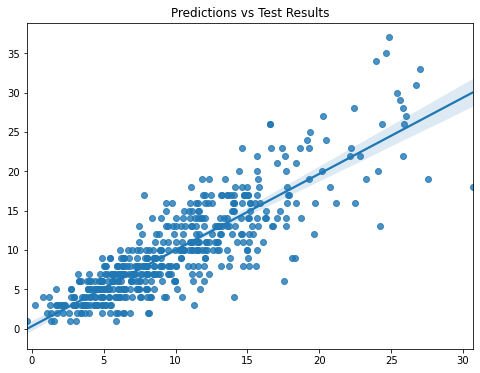

In [68]:
preds = svr_gs.predict(Xte_top_scaled)

fig, ax = plt.subplots(figsize=(8,6))
sns.regplot(x=preds, y=yte_top).set_title('Predictions vs Test Results');

# Conclusion

It appears that the most important features when creating a model here is the number of recent victims and what day of the week it is. Contrary to initial thought the month of the model does not seem to be impactful (possibly because recent victims already accounts for spikes per month). Additionally different kinds of demographics do not seem to effect the model.

Possible next steps are trying to localize models to different neighborhoods in Chicago, as well as investigating time series. Additionally I will build a dashboard so users can input day of week and victim counts in to get a prediction.

## Pickling a Model for Dashboard

In [69]:
model_pipeline = Pipeline([('scaler', StandardScaler()),
                          ('sgd', SGDRegressor(epsilon=0.01,  penalty='l2', tol=0.001))])

In [70]:
X_train = X_train[top_list]
# X_train['rolling_count'] = X_train['so_yes_no_no'] + X_train['so_yes_no_yes']
# X_train.drop(['so_yes_no_no', 'so_yes_no_yes'], axis=1, inplace=True)

In [71]:
X_train

,so_yes_no_no,so_yes_no_yes,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
date,,,,,,,,
2016-09-20,2.0,18.0,0,0,1,0,0,0
2018-01-18,3.0,8.0,0,0,0,0,1,0
2019-10-16,4.0,5.0,0,0,0,1,0,0
2016-08-30,7.0,24.0,0,0,1,0,0,0
2020-07-09,5.0,16.0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
2019-02-07,3.0,10.0,0,0,0,0,1,0
2019-07-22,8.0,16.0,0,1,0,0,0,0
2018-05-13,7.0,12.0,1,0,0,0,0,0


In [72]:
X_test = X_test[top_list]
# X_test['rolling_count'] = X_test['so_yes_no_no'] + X_test['so_yes_no_yes']
# X_test.drop(['so_yes_no_no', 'so_yes_no_yes'], axis=1, inplace=True)

In [73]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDRegressor(epsilon=0.01))])

In [74]:
model_pipeline.score(X_test, y_test)

0.7451376444767881

In [78]:
model_df

,primary_type_fatal,primary_type_non_fatal,so_yes_no_no,so_yes_no_yes,beat_1011,beat_1012,beat_1013,beat_1014,beat_1021,beat_1022,beat_1023,beat_1024,beat_1031,beat_1032,beat_1033,beat_1034,beat_111,beat_1111,beat_1112,beat_1113,beat_1114,beat_1115,beat_112,beat_1121,beat_1122,beat_1123,beat_1124,beat_1125,beat_113,beat_1131,beat_1132,beat_1133,beat_1134,beat_1135,beat_114,beat_121,beat_1211,beat_1212,beat_1213,beat_1214,beat_1215,beat_122,beat_1221,beat_1222,beat_1223,beat_1224,beat_1225,beat_123,beat_1231,beat_1232,beat_1233,beat_1234,beat_1235,beat_124,beat_131,beat_132,beat_133,beat_1411,beat_1412,beat_1413,beat_1414,beat_1421,beat_1422,beat_1423,beat_1424,beat_1431,beat_1432,beat_1433,beat_1434,beat_1511,beat_1512,beat_1513,beat_1522,beat_1523,beat_1524,beat_1531,beat_1532,beat_1533,beat_1611,beat_1613,beat_1614,beat_1622,beat_1623,beat_1624,beat_1631,beat_1632,beat_1633,beat_1634,beat_1654,beat_1711,beat_1712,beat_1713,beat_1722,beat_1723,beat_1724,beat_1731,beat_1732,beat_1733,beat_1811,beat_1812,beat_1813,beat_1814,beat_1821,beat_1822,beat_1823,beat_1824,beat_1831,beat_1832,beat_1833,beat_1834,beat_1911,beat_1912,beat_1913,beat_1914,beat_1915,beat_1921,beat_1922,beat_1923,beat_1924,beat_1925,beat_1931,beat_1932,beat_1933,beat_1934,beat_1935,beat_2011,beat_2012,beat_2013,beat_2022,beat_2023,beat_2024,beat_2031,beat_2032,beat_2033,beat_211,beat_212,beat_213,beat_214,beat_215,beat_221,beat_2211,beat_2212,beat_2213,beat_222,beat_2221,beat_2222,beat_2223,beat_223,beat_2232,beat_2233,beat_2234,beat_224,beat_225,beat_231,beat_232,beat_233,beat_234,beat_235,beat_2411,beat_2412,beat_2413,beat_2422,beat_2423,beat_2424,beat_2431,beat_2432,beat_2433,beat_2511,beat_2512,beat_2513,beat_2514,beat_2515,beat_2521,beat_2522,beat_2523,beat_2524,beat_2525,beat_2531,beat_2532,beat_2533,beat_2534,beat_2535,beat_311,beat_312,beat_313,beat_314,beat_321,beat_322,beat_323,beat_324,beat_331,beat_332,beat_333,beat_334,beat_411,beat_412,beat_413,beat_414,beat_421,beat_422,beat_423,beat_424,beat_431,beat_432,beat_433,beat_434,beat_511,beat_512,beat_513,beat_522,beat_523,beat_524,beat_531,beat_532,beat_533,beat_611,beat_612,beat_613,beat_614,beat_621,beat_622,beat_623,beat_624,beat_631,beat_632,beat_633,beat_634,beat_711,beat_712,beat_713,beat_714,beat_715,beat_722,beat_723,beat_724,beat_725,beat_726,beat_731,beat_732,beat_733,beat_734,beat_735,beat_811,beat_812,beat_813,beat_814,beat_815,beat_821,beat_822,beat_823,beat_824,beat_825,beat_831,beat_832,beat_833,beat_834,beat_835,beat_911,beat_912,beat_913,beat_914,beat_915,beat_921,beat_922,beat_923,beat_924,beat_925,beat_931,beat_932,beat_933,beat_934,beat_935,age_0 - 19,age_20 - 29,age_30 - 39,age_40 - 49,age_50 - 59,age_60 - 69,age_70 - 79,age_80+,age_UNKNOWN,sex_F,sex_M,sex_SEX_UNKNOWN,race_(NOT PROVIDED),race_API,race_BLK,race_I,race_U,race_WBH,race_WHI,race_WWH,community_area_ALBANY PARK,community_area_ARCHER HEIGHTS,community_area_ARMOUR SQUARE,community_area_ASHBURN,community_area_AUBURN GRESHAM,community_area_AUSTIN,community_area_AVALON PARK,community_area_AVONDALE,community_area_BELMONT CRAGIN,community_area_BEVERLY,community_area_BRIDGEPORT,community_area_BRIGHTON PARK,community_area_BURNSIDE,community_area_CALUMET HEIGHTS,community_area_CHATHAM,community_area_CHICAGO LAWN,community_area_CLEARING,community_area_DOUGLAS,community_area_DUNNING,community_area_EAST GARFIELD PARK,community_area_EAST SIDE,community_area_EDGEWATER,community_area_EDISON PARK,community_area_ENGLEWOOD,community_area_FOREST GLEN,community_area_FULLER PARK,community_area_GAGE PARK,community_area_GARFIELD RIDGE,community_area_GRAND BOULEVARD,community_area_GREATER GRAND CROSSING,community_area_HEGEWISCH,community_area_HERMOSA,community_area_HUMBOLDT PARK,community_area_HYDE PARK,community_area_IRVING PARK,community_area_JEFFERSON PARK,community_area_KENWOOD,community_area_LAKE VIEW,community_area_LINCOLN PARK,community_area_LINCOLN SQUARE,community_area_LOGAN SQUARE,community_area_LOOP,community_area_LOWER WEST SIDE,co